In [2]:
import re
import glob
from pathlib import Path

def last_log_likelihood(path):
    path = Path(path)
    text = path.read_text()
    # Find header line containing 'Estimated Log Likelihood' and parse following numeric rows.
    lines = text.splitlines()
    header_idx = None
    for i, l in enumerate(lines):
        if 'Estimated Log Likelihood' in l:
            header_idx = i
            break
    pat = re.compile(r'^\s*(\d+)\s+([-+]?[0-9]*\.?[0-9]+(?:[eE][-+]?\d+)?)')
    vals = []
    if header_idx is not None:
        for l in lines[header_idx+1:]:
            m = pat.match(l)
            if m:
                # Group 2 is the numeric log likelihood value
                vals.append(float(m.group(2)))
            # stop if we hit the section that writes files
            if l.strip().startswith('Writing to file'):
                # continue scanning in case more numeric rows exist, but it's okay to continue
                continue
    else:
        # fallback: scan whole file for iteration-number rows
        for l in lines:
            m = pat.match(l)
            if m:
                vals.append(float(m.group(2)))
    return vals[-1] if vals else None

# Parse all *.output.txt files in current directory
results = {}
for fp in sorted(glob.glob('*.log')):
    try:
        model = fp.split('.')[0]
        states = model.split('_')[1]
        # print(states)
        results[states] = last_log_likelihood(fp)
    except Exception as e:
        results[states] = f'ERROR: {e}'

# Display results nicely
from pprint import pprint
pprint(results)

{'1': -16447916.918,
 '11': -8224727.572,
 '13': -8177340.954,
 '14': -8044504.066,
 '15': -8028278.12,
 '16': -7996161.222,
 '17': -7979488.608,
 '18': -7919783.024,
 '19': -7887285.739,
 '2': -13794345.258,
 '21': -7852111.189,
 '22': -7832811.202,
 '23': -7824691.29,
 '24': -7818565.428,
 '25': -7807893.599,
 '3': -10105369.678,
 '4': -9525450.281,
 '5': -8990281.947,
 '6': -8857868.732,
 '7': -8692600.804,
 '8': -8488002.117,
 '9': -8521211.706,
 'model': -7875489.196}


In [5]:
import pandas as pd
# print(results)
df = pd.DataFrame.from_dict(results, orient='index')
df = df.reset_index()
df.columns = ['States', 'Log Likelihood']
df['States'] = pd.to_numeric(df['States'], errors='coerce')
sorted_df = df.sort_values('States')
print(sorted_df)

    States  Log Likelihood
1      1.0   -1.644792e+07
10     2.0   -1.379435e+07
16     3.0   -1.010537e+07
17     4.0   -9.525450e+06
18     5.0   -8.990282e+06
19     6.0   -8.857869e+06
20     7.0   -8.692601e+06
21     8.0   -8.488002e+06
22     9.0   -8.521212e+06
2     11.0   -8.224728e+06
3     13.0   -8.177341e+06
4     14.0   -8.044504e+06
5     15.0   -8.028278e+06
6     16.0   -7.996161e+06
7     17.0   -7.979489e+06
8     18.0   -7.919783e+06
9     19.0   -7.887286e+06
11    21.0   -7.852111e+06
12    22.0   -7.832811e+06
13    23.0   -7.824691e+06
14    24.0   -7.818565e+06
15    25.0   -7.807894e+06
0      NaN   -7.875489e+06


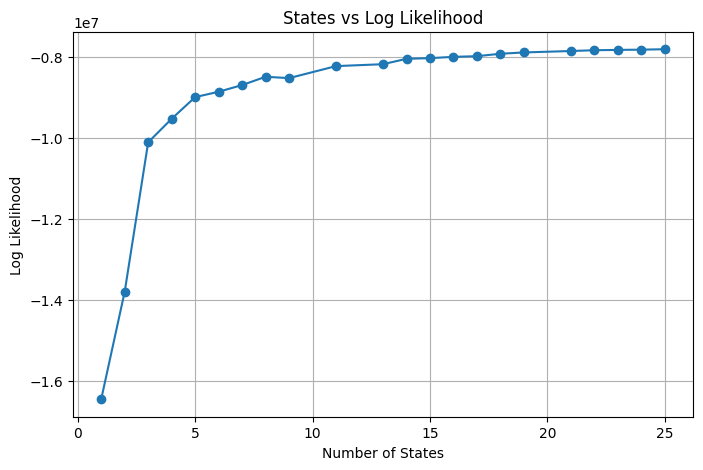

In [6]:
import matplotlib.pyplot as plt

# Plot log likelihood by number of states
plt.figure(figsize=(8,5))
plt.plot(sorted_df["States"], sorted_df["Log Likelihood"], marker='o')
plt.xlabel("Number of States")
plt.ylabel("Log Likelihood")
plt.title("States vs Log Likelihood")
plt.grid(True)
plt.show()


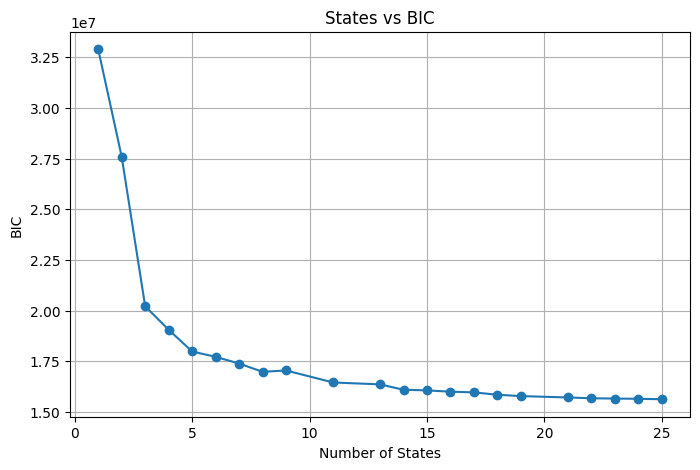

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# calculate BIC 

M = 6
bin_size = 200
hg19 = 45841531
mm10 = 27293334

n = mm10 // bin_size  # number of bins in hg19
S = sorted_df["States"].values
logL = sorted_df["Log Likelihood"].values

# Parameter count k(S) = emission + transition + initial
k = S * M + S * (S - 1) + (S - 1)

bic = -2 * logL + k * np.log(n)

sorted_df["k"] = k
sorted_df["BIC"] = bic


plt.figure(figsize=(8,5))
plt.plot(sorted_df["States"], sorted_df["BIC"], marker='o')
plt.xlabel("Number of States")
plt.ylabel("BIC")
plt.title("States vs BIC")
plt.grid(True)
plt.show()


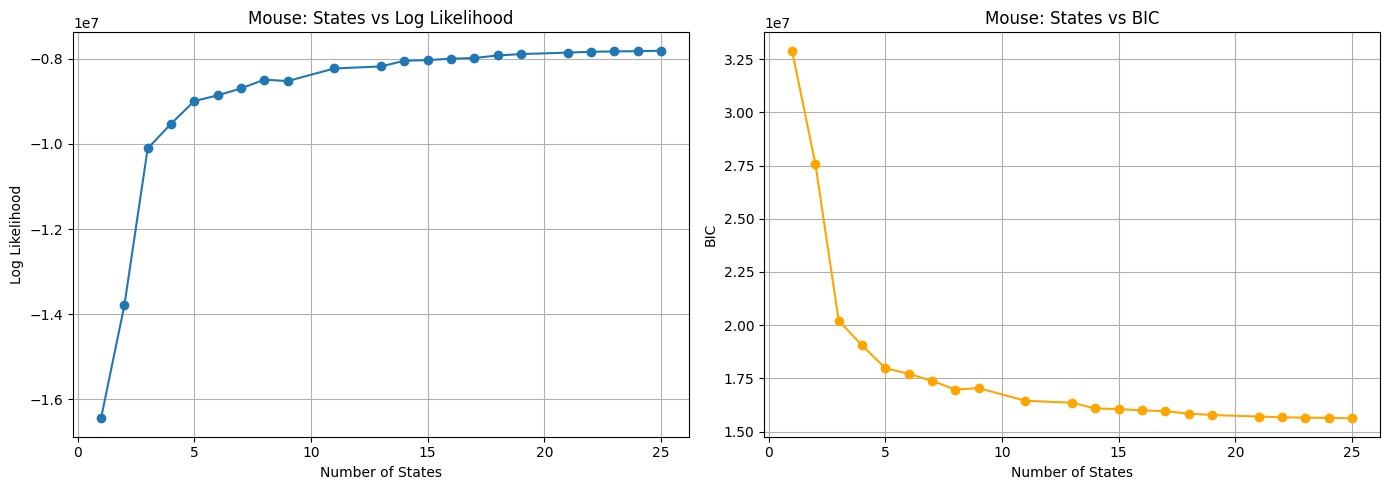

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- Compute BIC as you already did ---
M = 6
bin_size = 200
hg19 = 45841531
mm10 = 27293334

n = mm10 // bin_size   # number of bins
S = sorted_df["States"].values
logL = sorted_df["Log Likelihood"].values

# Parameter count: emission + transition + initial probabilities
k = S * M + S * (S - 1) + (S - 1)

bic = -2 * logL + k * np.log(n)

sorted_df["k"] = k
sorted_df["BIC"] = bic

# --- Side-by-side plots ---
fig, axes = plt.subplots(1, 2, figsize=(14,5))

# Plot 1: Log Likelihood
axes[0].plot(sorted_df["States"], sorted_df["Log Likelihood"], marker='o')
axes[0].set_xlabel("Number of States")
axes[0].set_ylabel("Log Likelihood")
axes[0].set_title("Mouse: States vs Log Likelihood")
axes[0].grid(True)

# Plot 2: BIC
axes[1].plot(sorted_df["States"], sorted_df["BIC"], marker='o', color='orange')
axes[1].set_xlabel("Number of States")
axes[1].set_ylabel("BIC")
axes[1].set_title("Mouse: States vs BIC")
axes[1].grid(True)

plt.tight_layout()
plt.show()
